In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from importlib.machinery import SourceFileLoader

# Initialise wrapper
wr = SourceFileLoader("mobius", r"../../PythonWrapper/mobius.py").load_module()
cu = SourceFileLoader("mobius_calib_uncert_lmfit", r"../../PythonWrapper/mobius_calib_uncert_lmfit.py").load_module()

wr.initialize('shrimpact.dll')

In [2]:
dataset = wr.DataSet.setup_from_parameter_and_input_files('testparameters.dat', 'testinputs.dat')

In [3]:
def do_large_run(dataset, nruns, timesteps, stdvs) :
    dataset_copy = dataset.copy()
    
    data = np.zeros((nruns, timesteps))
    
    dataset_copy.set_parameter_uint('Timesteps', [], timesteps)
    dataset_copy.set_parameter_enum('Bad year type', [], 'Multiple')  #None, Once, or Multiple
    
    vs = np.random.normal(1.0, stdvs, nruns)
    
    for idx in range(nruns) :
        dataset_copy.set_parameter_double('Variation in survival', [], vs[idx])
        dataset_copy.run_model()
        data[idx, :] = dataset_copy.get_result_series('Total adult population', [])
    
    x_values = cu.get_date_index(dataset_copy)
    
    dataset_copy.delete()
    
    return x_values, data

def get_population_survival_chance(data):
    return 100.0*np.sum(data[:,-1] > 0.1) / data.shape[0]

Populations survival chance: 100%


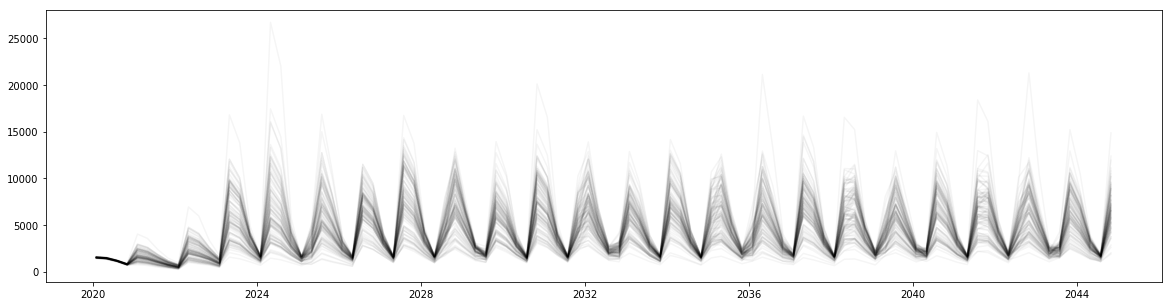

In [4]:
nruns = 100
timesteps = 100
stdvs = 0.1

x_values, data = do_large_run(dataset, nruns, timesteps, stdvs)

fig, ax = plt.subplots(1,1)

fig.set_size_inches(20, 5)



for idx in range(nruns):
    ax.plot(x_values, data[idx,:], color='black', alpha=0.04)
    
#fig.show()

print('Populations survival chance: %g%%' % get_population_survival_chance(data) )

In [5]:
def sensitivity_plot(dataset, parameter, par_range, samples, nruns, timesteps, stdvs) :
    results = np.zeros(samples)
    par_values = np.arange(par_range[0], par_range[1], (par_range[1]-par_range[0])/samples)

    dataset_copy = dataset.copy()
    for idx,par_value in enumerate(par_values) :
        dataset_copy.set_parameter_double(parameter, [], par_value)

        _, data = do_large_run(dataset_copy, nruns, timesteps, stdvs)

        results[idx] = get_population_survival_chance(data)

    dataset_copy.delete()

    fig, ax = plt.subplots(1,1)

    fig.set_size_inches(20, 5)

    ax.plot(par_values, results, color='black', label='Population survival chance as function of %s' % parameter)
    ax.legend()

    ax.set_ylim(0, 102)
    ax.set_xlabel(parameter)

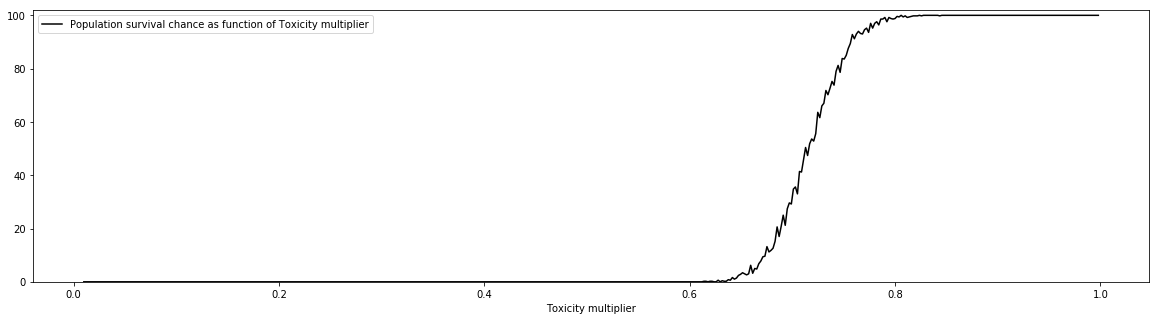

In [6]:
samples = 500

nruns = 500
timesteps = 100
stdvs = 0.1

sensitivity_plot(dataset, 'Toxicity multiplier', [0.01, 1.0], samples, nruns, timesteps, stdvs)